# sector 1

In [1]:
import os
os.chdir('../../scripts')
import pandas as pd
import matplotlib.pyplot as plt
from post_processing import get_output
from analysis_tools_cython import *
import seaborn as sns
plt.rcParams['figure.figsize'] = [12,7]

## Import Data

In [2]:
# data = get_output('../combined_dataframe.txt')
# data.head()

In [3]:
data = get_output('../output_log/s4.txt')
length = len(data)

- Change path to storage

In [4]:
data = data[data.transit_prob == 'maybeTransit']
data['abs_path'] = data['path'].str.replace('/tmp/tess/', '/storage/astro2/phrdhx/tesslcs/')
print(len(data), f"after maybeTransit, {len(data)/length *100}% candidates remain")
data.head()

66097 after maybeTransit, 27.3107785371336% candidates remain


,path,TIC_ID,signal,snr,time,asym_score,amplitude,width,skewness,skewness_err,...,chisq_gauss,chisq_skew,rchisq_gauss,rchisq_skew,rmse_gauss,rmse_skew,mae_gauss,mae_skew,transit_prob,abs_path
8,/tmp/tess/tesslcs_sector_4_104/2_min_cadence_t...,149174992,-4.67369,-4.43061,1414.21986,0.85615,0.00000,0.00092,30.00000,0.000000e+00,...,34.31802,39.94110,1.31992,1.53620,0.00080,0.00086,0.00058,0.00067,maybeTransit,/storage/astro2/phrdhx/tesslcs/tesslcs_sector_...
17,/tmp/tess/tesslcs_sector_4_104/tesslcs_tmag_10...,129840642,-6.57228,-3.56119,1429.88892,1.15133,0.00100,1.02261,29.99832,5.010418e+01,...,234.51904,203.78983,2.02172,1.75681,0.00062,0.00058,0.00050,0.00046,maybeTransit,/storage/astro2/phrdhx/tesslcs/tesslcs_sector_...
18,/tmp/tess/tesslcs_sector_4_104/2_min_cadence_t...,278022047,-4.93441,-4.18471,1430.34310,1.03564,0.00005,0.06630,-7.35986,2.078916e+01,...,28.68069,27.69332,1.43403,1.38467,0.00017,0.00017,0.00013,0.00012,maybeTransit,/storage/astro2/phrdhx/tesslcs/tesslcs_sector_...
19,/tmp/tess/tesslcs_sector_4_104/tesslcs_tmag_11...,141977014,-4.63656,-4.37362,1434.82258,0.58648,0.00000,2578.80977,29.76166,9.937185e+12,...,14.99224,25.71758,0.74961,1.28588,0.00041,0.00054,0.00030,0.00039,maybeTransit,/storage/astro2/phrdhx/tesslcs/tesslcs_sector_...
21,/tmp/tess/tesslcs_sector_4_104/tesslcs_tmag_10...,152475584,-3.91331,-3.70817,1433.18014,1.07765,0.00033,0.32434,-3.29249,3.251430e+00,...,25.89687,24.13576,0.99603,0.92830,0.00027,0.00026,0.00021,0.00020,maybeTransit,/storage/astro2/phrdhx/tesslcs/tesslcs_sector_...


## Removing worst anomalies

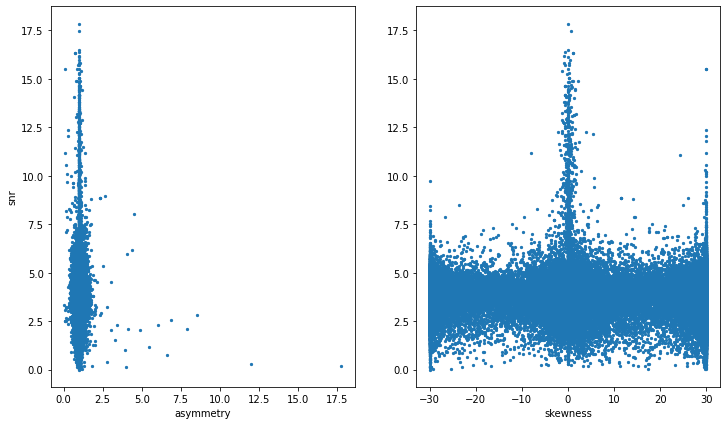

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(data.asym_score,abs(data.snr),s=5)
ax[0].set_xlabel("asymmetry")
ax[1].set_xlabel("skewness")
ax[0].set_ylabel("snr")
ax[1].scatter(data.skewness,abs(data.snr),s=5)
plt.show()

In [6]:
data = data[(data.asym_score <= 3)].reset_index(drop=True)

---

### Some EDA

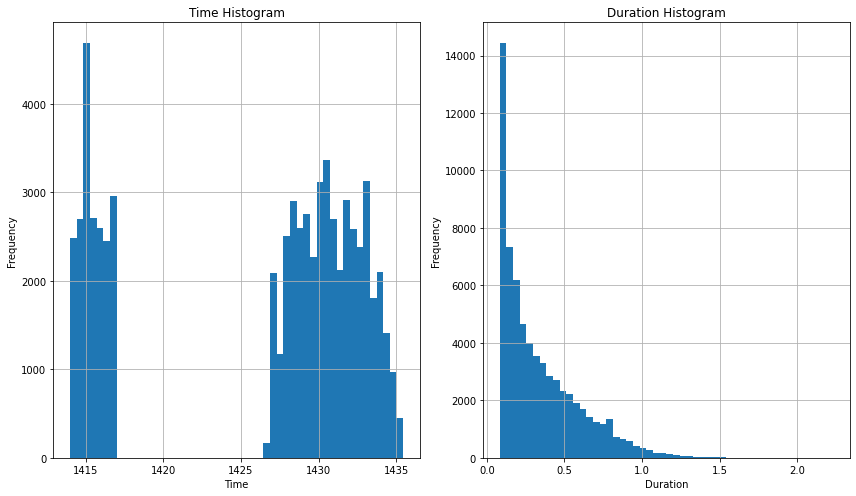

In [7]:
fig, axes = plt.subplots(1, 2)

# Plot the histogram for 'time' in the first subplot
data['time'].hist(bins=50, ax=axes[0])
axes[0].set_title('Time Histogram')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Frequency')

# Plot the histogram for 'duration' in the second subplot
data['duration'].hist(bins=50, ax=axes[1])
axes[1].set_title('Duration Histogram')
axes[1].set_xlabel('Duration')
axes[1].set_ylabel('Frequency')

# Adjust layout to prevent overlapping of titles and labels
plt.tight_layout()

# Show the subplots
plt.show()

## SNR cut

In [8]:
data_new = data[abs(data.snr) >= 5].reset_index(drop=True)
len(data_new)

4908

## Duration cut

In [9]:
data_new.drop(data_new[data_new['duration'] <= 0.4].index,inplace=True)

## Depth cut

In [10]:
data_new['abs_depth'] = abs(data_new.depth)

In [11]:
data_new.drop(data_new[(data_new['abs_depth'] >= 0.1)].index,inplace=True)

---

## Remaining Candidates

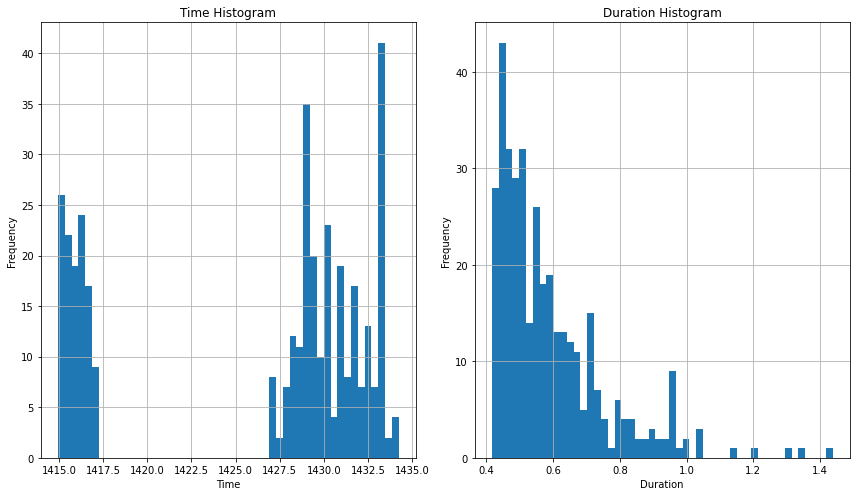

In [12]:
fig, axes = plt.subplots(1, 2)

# Plot the histogram for 'time' in the first subplot
data_new['time'].hist(bins=50, ax=axes[0])
axes[0].set_title('Time Histogram')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Frequency')

# Plot the histogram for 'duration' in the second subplot
data_new['duration'].hist(bins=50, ax=axes[1])
axes[1].set_title('Duration Histogram')
axes[1].set_xlabel('Duration')
axes[1].set_ylabel('Frequency')

# Adjust layout to prevent overlapping of titles and labels
plt.tight_layout()

# Show the subplots
plt.show()

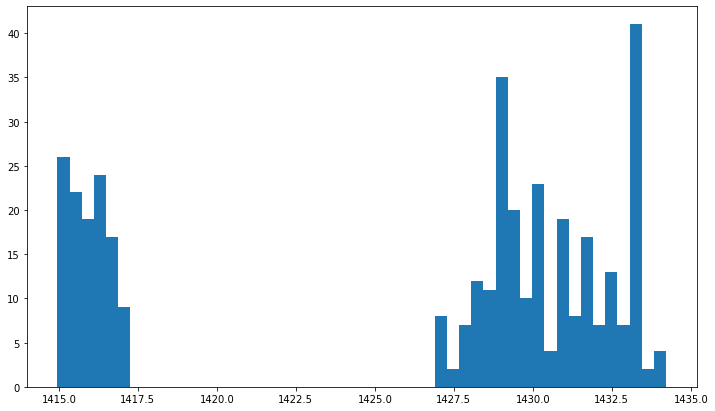

In [13]:
hist_values, bin_edges, _ = plt.hist(data_new['time'], bins=50)
#duration_hist_values, duration_bin_edges, _ = plt.hist(data_new['duration'], bins=50)

# Find the index of the bin with the maximum count
max_bin_index = np.argmax(hist_values)

# Retrieve the bin count and bin edges for the bin with the most count
max_bin_count = hist_values[max_bin_index]
bin_left_edge = bin_edges[max_bin_index]
bin_right_edge = bin_edges[max_bin_index + 1]

In [14]:
hist_values

array([26., 22., 19., 24., 17.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  8.,  2.,  7., 12., 11., 35., 20., 10.,
       23.,  4., 19.,  8., 17.,  7., 13.,  7., 41.,  2.,  4.])

In [16]:
# # Filter the DataFrame for data within the specified time bin
# subset_data = data_new[(data_new['time'] >= bin_left_edge) ]

# # Calculate the histogram for the 'duration' column within the time bin
# duration_hist_values, duration_bin_edges = np.histogram(subset_data['duration'], bins=50)

# max_duration_bin_index = np.argmax(duration_hist_values)

# # Retrieve the bin count and bin edges for the most common duration bin within the time bin
# max_duration_bin_count = duration_hist_values[max_duration_bin_index]
# duration_bin_left_edge = duration_bin_edges[max_duration_bin_index]
# duration_bin_right_edge = duration_bin_edges[max_duration_bin_index + 1]

# plt.hist(subset_data['duration'], bins=10, alpha=0.7)  # Adjust color and alpha as desired
# plt.show()

In [17]:
print(bin_left_edge, "start of bin")
print(bin_right_edge, "end of bin")
print(max_bin_count, "number of lcs")

1433.0635408 start of bin
1433.4488772 end of bin
41.0 number of lcs


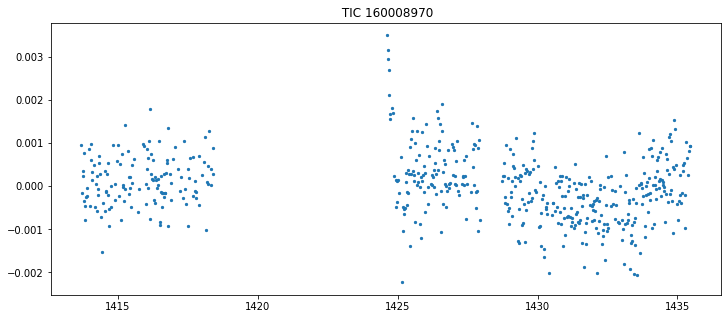

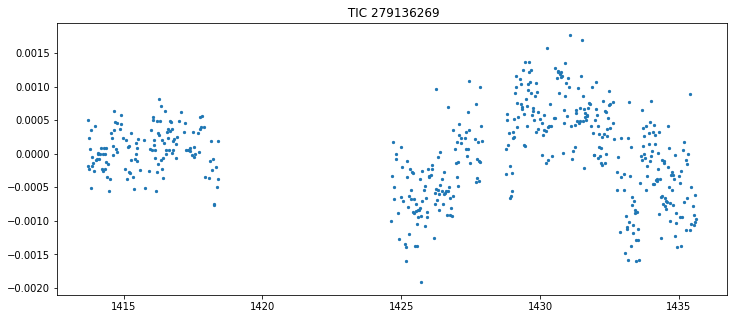

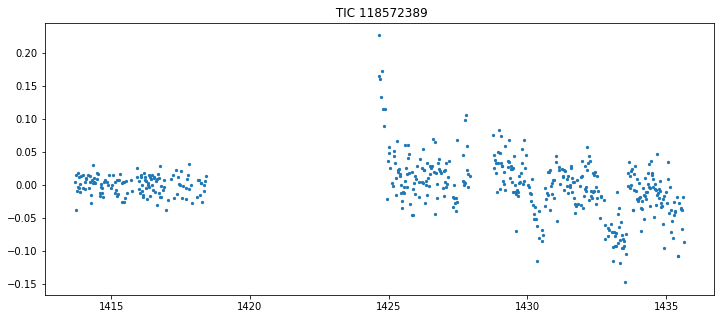

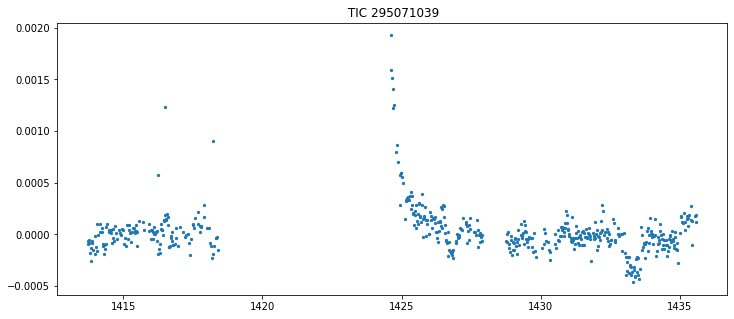

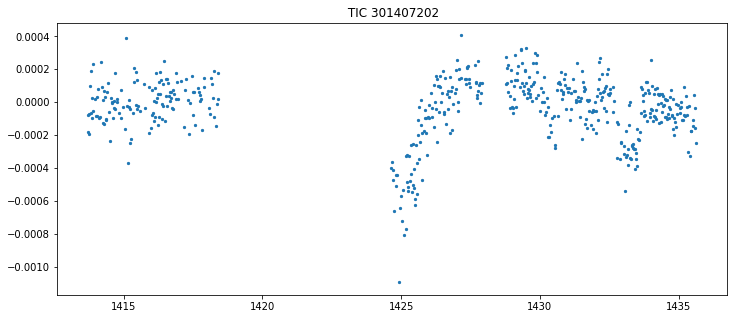

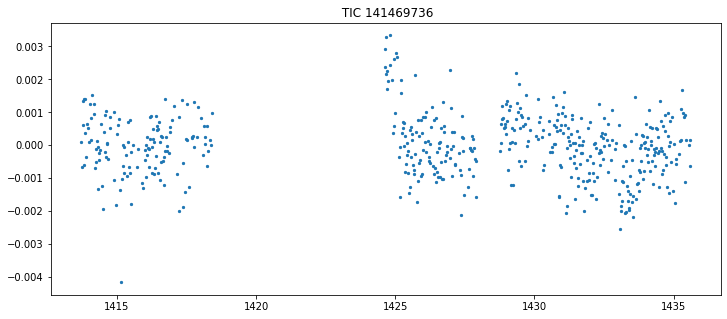

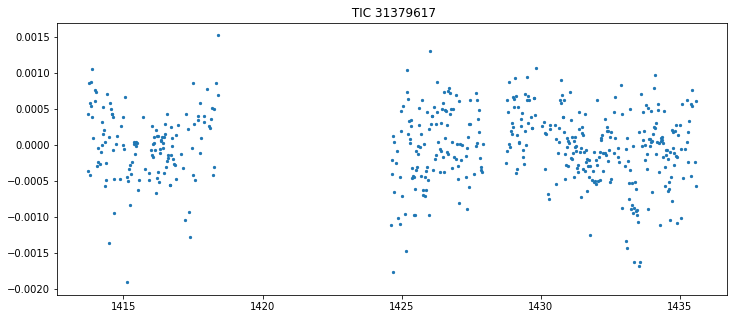

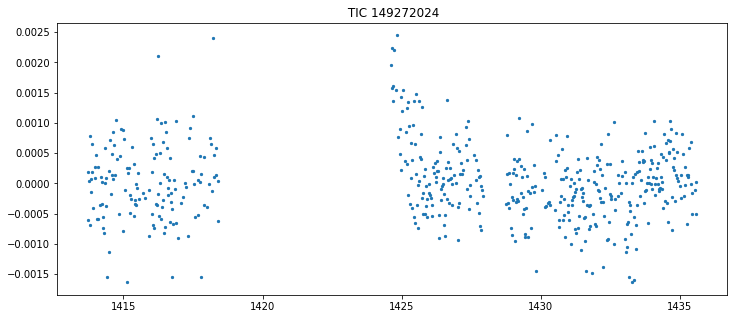

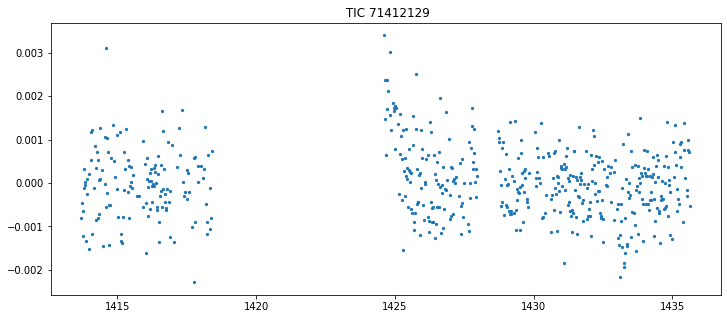

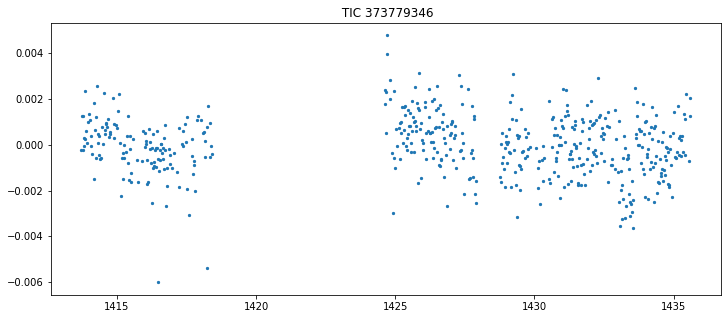

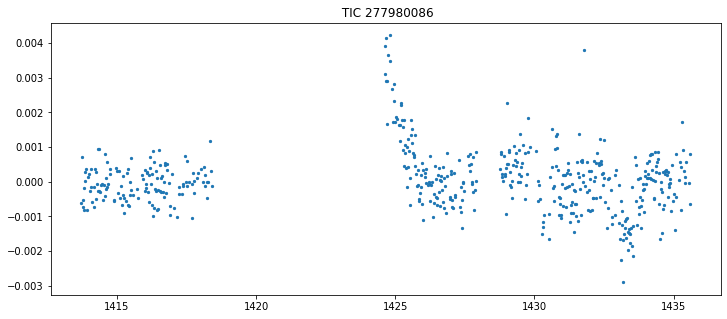

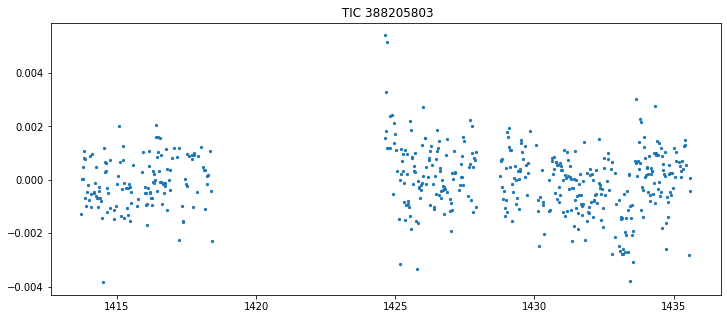

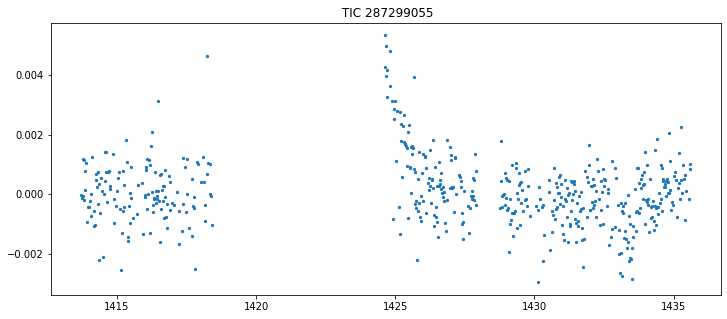

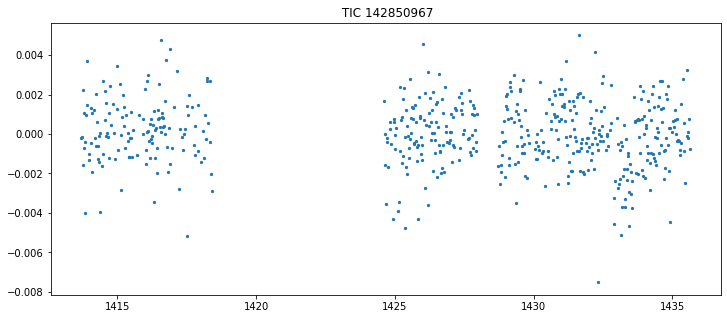

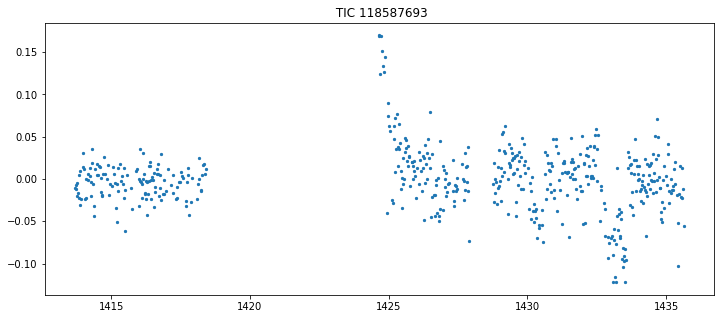

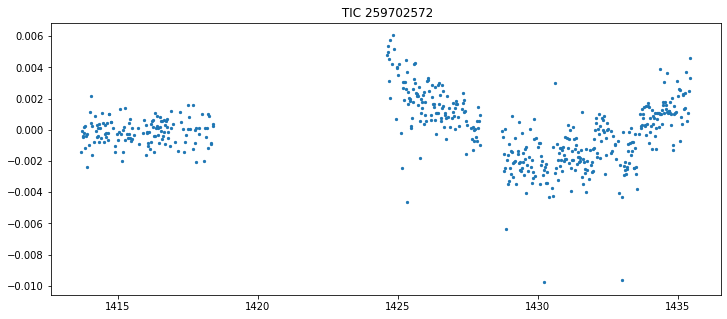

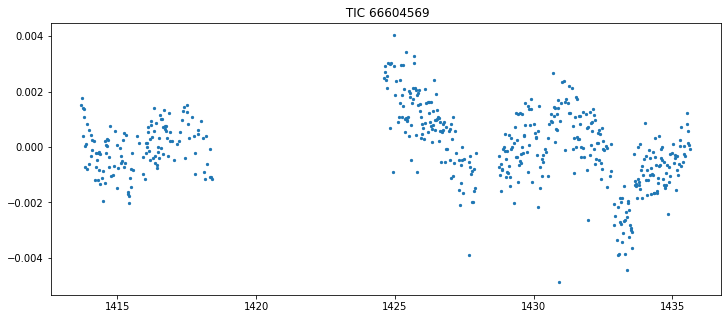

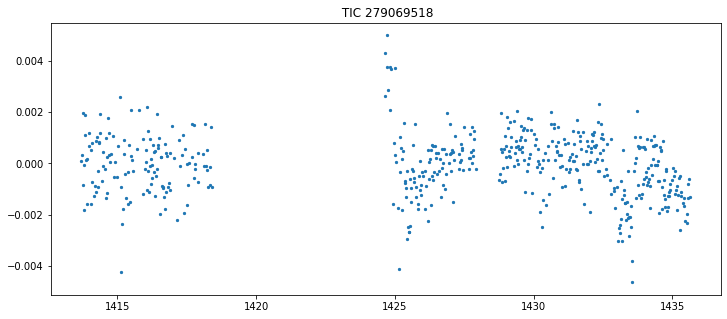

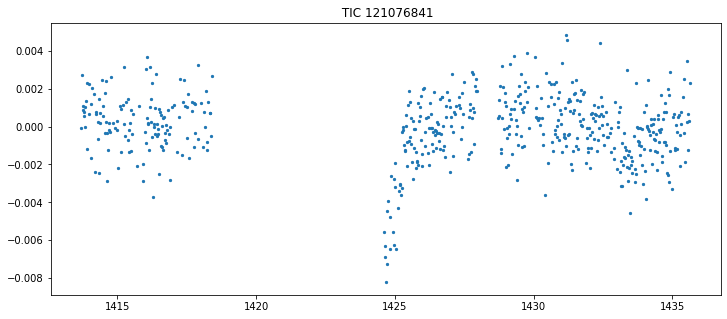

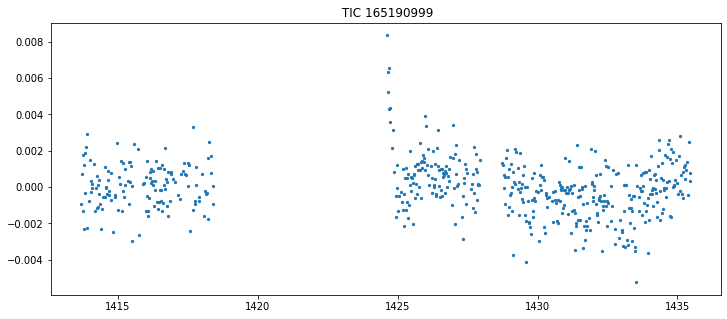

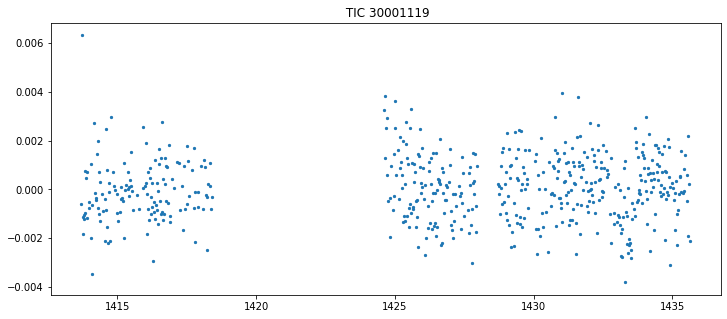

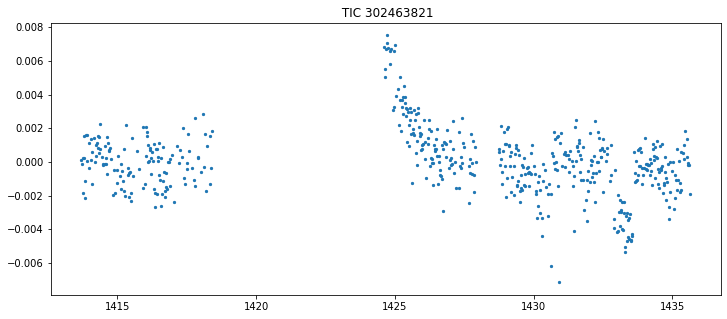

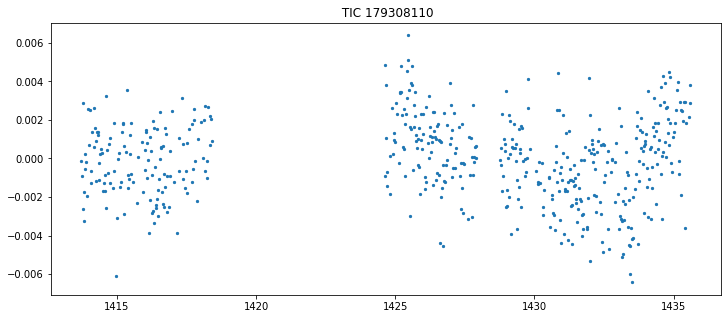

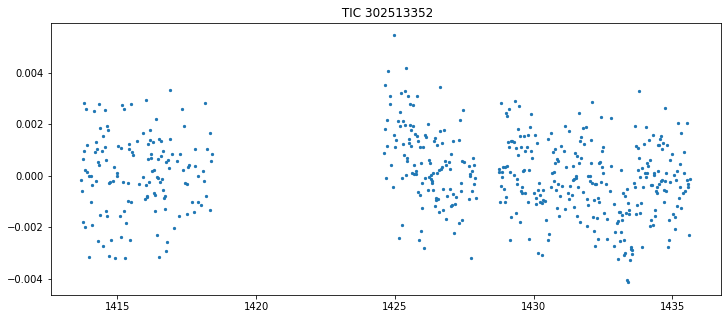

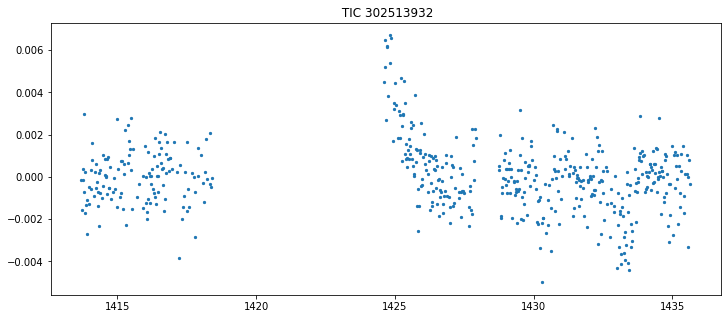

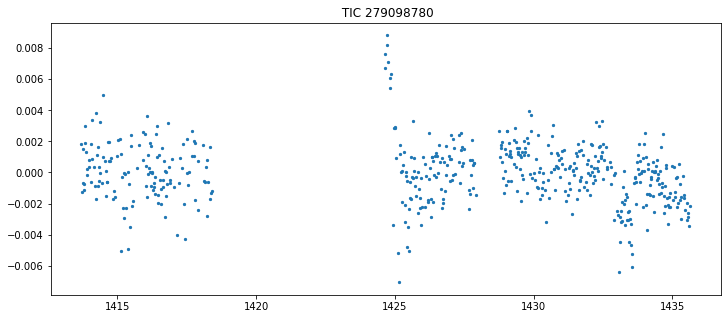

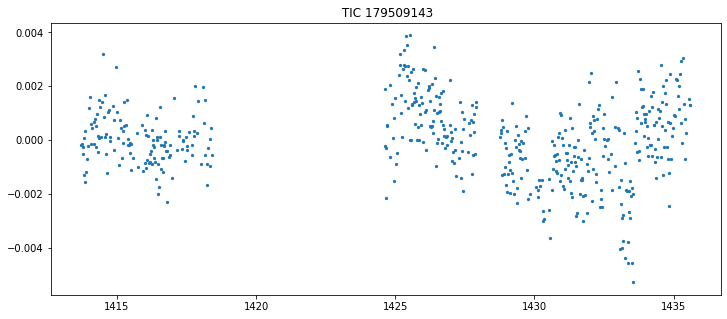

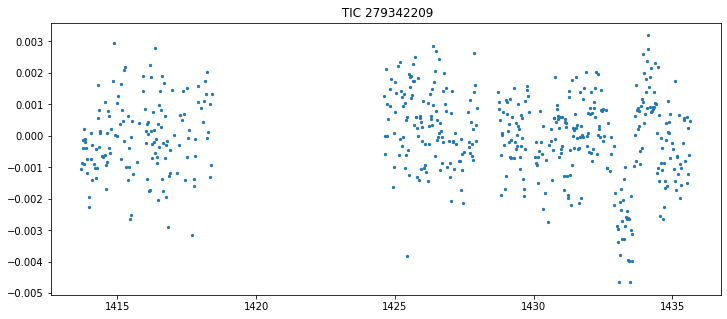

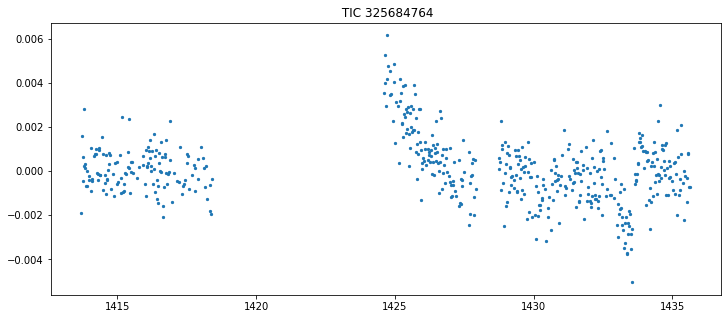

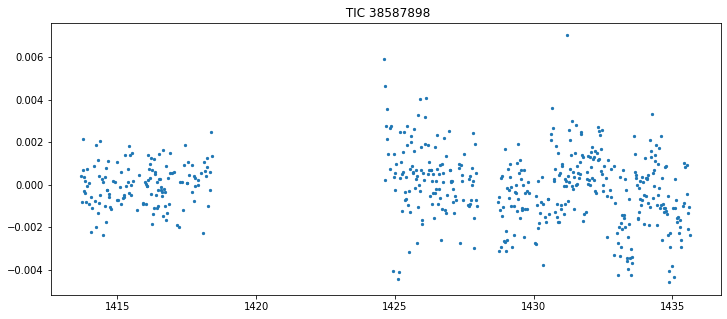

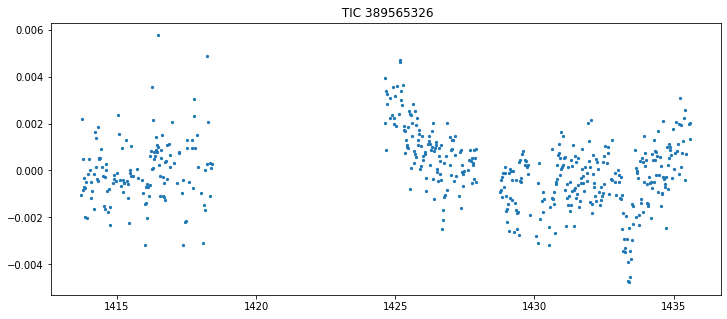

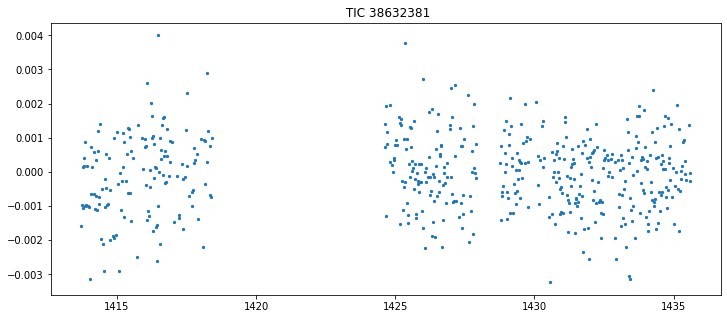

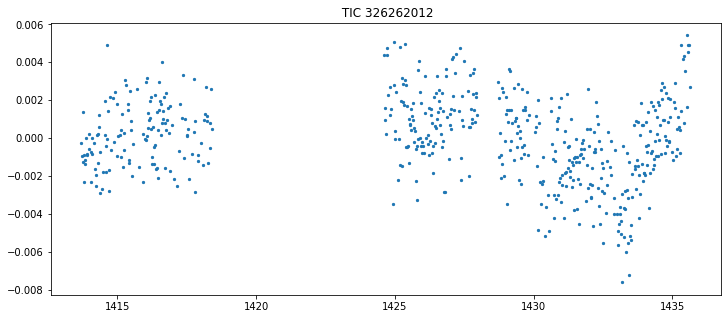

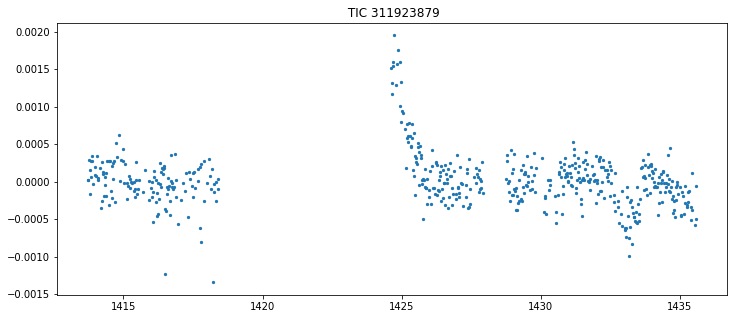

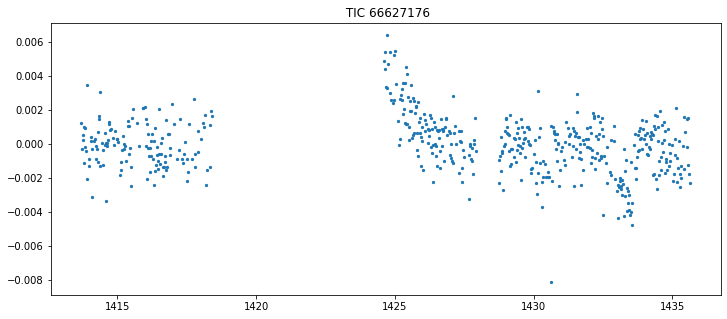

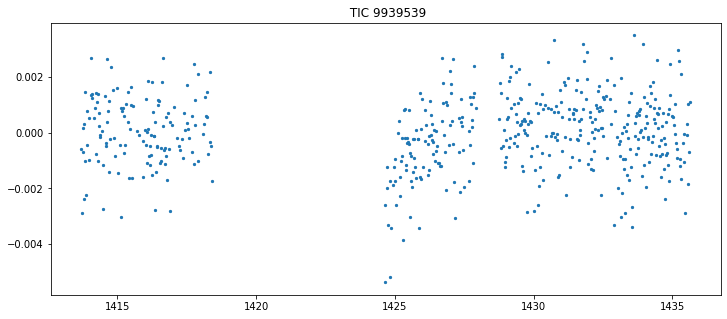

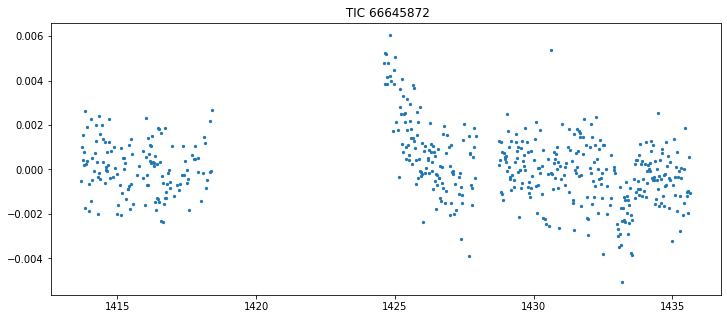

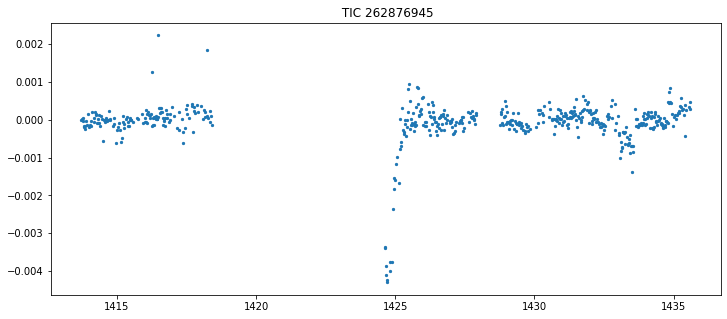

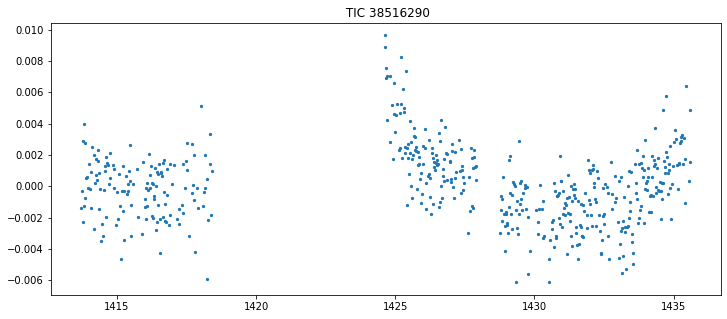

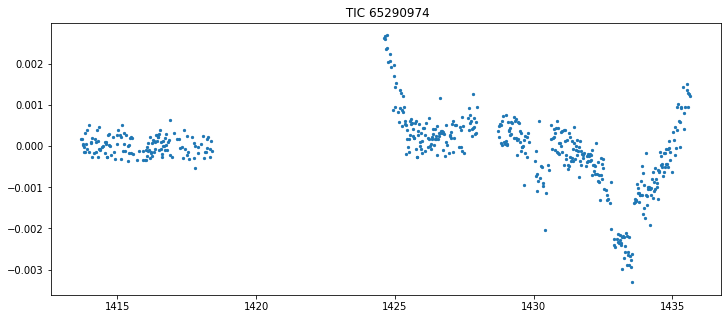

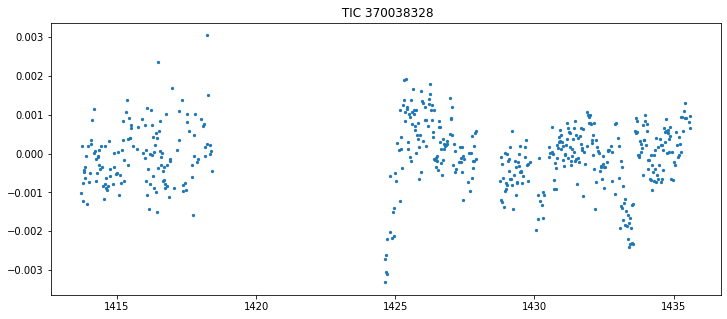

In [18]:
for i in data_new[(data_new.time >= bin_left_edge) & (data_new.time <= bin_right_edge)].abs_path.head(50): #4 x 4 grid for illustration purposes
    lc, lc_info = import_XRPlightcurve(i,sector=1)
    plt.figure(figsize=(12,5))
    plt.scatter(lc['time'],normalise_flux(lc['corrected flux']), s=5)
    plt.title(f' TIC {lc_info[0]}')
    plt.show()